# カノニカル（NVT）アンサンブル

## TL;DR

- NVT-MDシミュレーションは温度および体積を一定とするシミュレーションで、体積変化や温度変化を無視したいときに使える計算方法。
- 用途としては固体中のイオン拡散、スラブ構造表面での吸着や反応、クラスター上の吸着や反応など。
- NVT-MDシミュレーションの方法は温度をコントロールする熱浴法によりバリエーションがいくつか存在し、Berendsen熱浴、Langevin熱浴、NoseHoover熱浴などが一般的でASEにも実装されている。
- Berendsen熱浴法は簡便で収束性も良いが、系全体の原子の速度分布を一律に変更するため不自然な現象が起こり得る。
- Langevin熱浴法は統計的手法で適切にサンプリングされたランダム力を個々の原子に与えることで温度を制御する。各原子を個別に制御するため混相のようなものでも適切に扱える。計算を繰り返しても同じ軌道を再現しないため精密に軌道を解析するのには不向き。
- Nosé–Hoover熱浴法は最も汎用的に利用される温度制御法のひとつ。原理的に正しいNVTアンサンブルを再現するが特殊な系で例外が存在する。

</br>

前節ではMDシミュレーションの最もシンプルな形であるNVEアンサンブルのMDシミュレーションついて学びました。

つづいて、よく使われる状態分布のひとつである<a href="https://ja.wikipedia.org/wiki/%E6%AD%A3%E6%BA%96%E9%9B%86%E5%9B%A3">カノニカルアンサンブル</a>（正準状態分布とも呼びます）におけるMDシミュレーションについて説明します。カノニカルアンサンブルは粒子数（N）、体積（V）、温度（T）が一定の統計力学的な状態分布です。検討したい対象で体積変化が無視できるような場合に適用されます。たとえば比較的低温領域で体積膨張が無視できるようなシミュレーションが良い例になります。

いくつかの実践的な具体的な例を通して、代表的な手法についてみていきましょう。

## 計算事例１： fcc-Alの溶融

一つ目の事例として6-1節で扱った金属アルミニウムの溶融状態の計算方法についてみてみましょう。

6-1節では金属アルミニウムが十分に溶融して見えるように1600 Kという高い初期温度でシミュレーションを行いました。しかし、**今回は初期温度を1000 K**で計算してみます。NVEアンサンブルでの計算方法は前節と一緒で温度を1000 Kに設定するだけです。これを実行した結果が以下のようになります。

<br>
<figure style="text-align:center">
  <img src="../assets/ch6/Fig6-2_fcc-Al_NVE_1000Kstart.png" alt="fcc-Al_NVE_1000Kstart">
  <figcaption>Fig6-2a. Fcc-Al in NVE ensemble starting at 1000 K</figcaption>
  <figcaption>(File: ../input/ch6/6-2_fcc-Al_NVE_1000Kstart.traj)</figcaption>
</figure>

確かに格子はだいぶ揺らいではいますが、元のFCCの結晶構造が明らかに見て取れると思います。Alの融点は933 Kですが、初期温度1000 Kでは不十分なようです。

続いてNVTアンサンブルで設定温度1000 Kで実行してみます。計算方法は以下のとおりです。計算時間は最初のNVEアンサンブルの計算と殆ど変わらないと思います。

In [1]:
import os
from asap3 import EMT
calculator = EMT()

import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = bulk("Al","fcc",a=4.3,cubic=True)
atoms.pbc = True
atoms *= 3
print("atoms = ",atoms)

# input parameters
time_step    = 1.0    # fsec
temperature  = 1000    # Kelvin
num_md_steps = 1000000 
num_interval = 10000
taut         = 1.0    # fs
    
atoms.calc = calculator
    
print(f"taut = {taut:.3f}")

output_filename = "./output/ch6/fcc-Al_NVT-Berendsen_1000K"
print("output_filename = ",output_filename)

log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)


# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# run MD
dyn = NVTBerendsen(atoms, time_step*units.fs, temperature_K = temperature, taut=taut*units.fs, loginterval=num_interval, trajectory=traj_filename)

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, output_filename+".log", header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Al108', pbc=True, cell=[12.899999999999999, 12.899999999999999, 12.899999999999999])
taut = 1.000
output_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K
log_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K.log
traj_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
    0   23.764    1000.00    7.17  7.14  7.08  7.30  0.08  0.12  0.07    0.002
  10000   42.640    1001.31    0.83  0.80  0.86  0.81  -0.12  -0.59  -0.15    2.098
  20000   43.716    996.81    0.48  0.38  0.44  0.62  0.30  -0.02  -0.00    4.170
  30000   43.096    994.42    0.83  0.89  0.68  0.90  0.06  0.06  -0.07    6.610
  40000   42.908    995.85    0.72  0.51  0.72  0.93  -0.31  -0.12  -0.09    8.731
  50000   43.791    992.83    0.46  1.08  0.03  0.25  -0.24  0.00  -0.73    10.865
  60000   42.992    1002.44    0.56  1.09  0.54  0.06  -0.17  -0.04  0.32    12.912
  70000   42.523    1004.48    0.7

True

今回は**Berendsen熱浴法**という方法を使っています。この計算手法では原子の速度を目標温度に近づくようにスケーリングして温度調整する方法です。（参考文献[1-3]）

具体的には、6-1節でも解説したように、温度と速度の関係は

$$K = \sum_{i=1}^{N} \frac{1}{2} m_i {\mathbf{v}}_i^2 = \frac{3}{2} k_B T$$

で与えられるため、温度をコントロールするために計算対象である系全体の原子の速度をスケールして制御しています。実際に速度をスケールする係数は以下の式で記述されます。

$$
\lambda = \sqrt{1+\frac{\Delta t}{\tau_T}\left(\frac{T_0}{T(t)}-1\right)}
$$

ここで$\Delta t$は時間ステップサイズ、$\tau_T$は熱浴の時定数です。この方法では時定数$\tau$をコントロールすることでより緩やかに目標温度に到達することが可能です。$\tau_T=\Delta t$のとき、いわゆる速度スケーリング法と呼ばれる最も単純な温度制御法と同一になります。（つまり $\lambda = \sqrt{T_0/T(t)}$ ）この場合、温度は常に所定の温度一定になり、温度の拘束条件が最大になっていると考えられます。逆に$\tau$が大きくなるにつれて温度制御は緩くなり、目標温度到達するのに時間がかかることになります。現実の物質の状態を考えるとある程度の緩和時間はあってしかるべきで、実用上はMDの計算時間に対して十分短くて済むような設定しするのが一般的です。ちなみに、この方法では系の温度は以下のように指数関数的に減衰するように補正されます。

$$
\frac{dT}{dt} = \frac{T_0-T}{\tau_T}
$$

それでは上記のNVT-MDシミュレーションの結果を見てみましょう。

In [2]:
from ase.io import Trajectory
from pfcc_extras.visualize.povray import traj_to_apng
from IPython.display import Image


traj = Trajectory(traj_filename)
traj_to_apng(traj, f"output/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_unwrap.png", rotation="0x,0y,0z", clean=True, n_jobs=16)

Image(url="output/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_unwrap.png")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:   10.2s finished


In [3]:
# Please remove comment out if you want to show trajectory in nglviewer.

from pfcc_extras.visualize.view import view_ngl
# view_ngl(traj)

<br>
<figure style="text-align:center">
  <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K.png" alt="fcc-Al_NVE_1000Kstart">
  <figcaption>Fig6-2b. Fcc-Al in NVT ensemble using Berendsen thermostat at 1000 K</figcaption>
  <figcaption>(File: ../input/ch6/6-2_fcc-Al_NVT-Berendsen_1000K.traj")</figcaption>
</figure>

先ほどのNVE計算と打って変わって構造は非常にダイナミックに動いており、挙動は複雑でほぼランダムに配置された溶融状態であることが見て取れます。これはNVTアンサンブルでの計算で常に温度が1000 Kになるようにコントロールされているので常に融点を超えた状態になっているためです。（注釈：実際ASEで実行した結果を見ると原子が激しく拡散してセルの外に広がっていくことが分かります。表示の便宜上、上図はwrap関数を用いて原子をセルの内側に戻して描画しています。）

以下のプロットがNVEとNVTアンサンブルで計算した場合の全エネルギー（Tot.E）、ポテンシャルエネルギー（PE）、運動エネルギー（KE）、系全体の温度（Temp.）の時間発展になります。当然ではありますが、NVEアンサンブルでは全エネルギー、NVTアンサンブルでは温度が一定になっていることが見て取れます。それに対してBerendsen 熱浴法では全エネルギーは揺らぎますが、運動エネルギーと温度はほぼ一定に保たれています。（実際は小さな揺らぎらありますが、グラフのスケールの問題で揺らぎが小さくて見えていません。）

<p class="aligncenter">
<div>
    <figure style="text-align: center">
        <img src="../assets/ch6/Fig6-2_fcc-Al_NVE-VelocityVerlet_1000K.png"/>
        <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_E_vs_t.png"/>
        <figcaption align = "center">Fig.6-2c. Comparison of energies and temperatures between NVE (top) and NVT (bottom) calculations.</figcaption>
    </figure>
</div>
</p>
</br>

上記のNVTに関するプロットは以下のように行うことができます。NVEに関しては前節をご参照ください。

In [11]:
import pandas as pd

df = pd.read_csv(
    log_filename,
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]",
           "stressxx", "stressyy", "stresszz", "stressyz", "stressxz", "stressxy"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K],stressxx,stressyy,stresszz,stressyz,stressxz,stressxy
0,0.1,-3.4368,-3.4670,0.0302,233.3,1.586,1.311,0.904,-0.118,-0.025,-0.255
1,0.2,-3.5662,-3.5964,0.0301,233.2,1.318,1.447,1.152,0.081,-0.109,-0.138


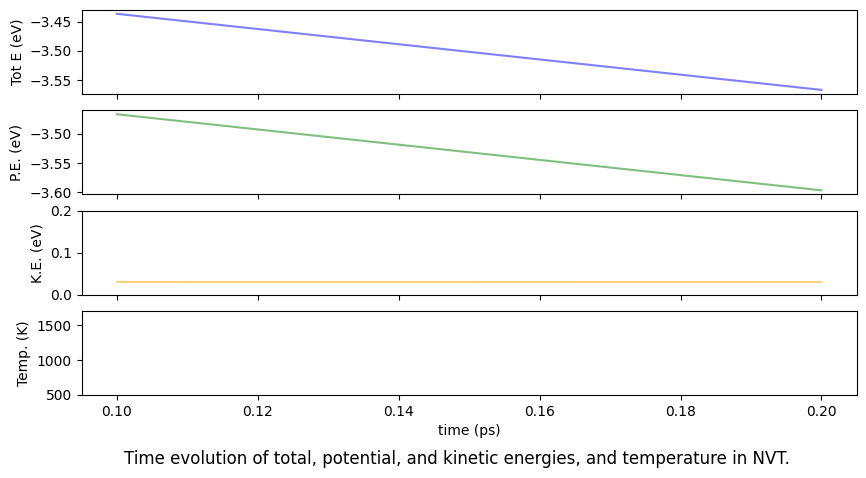

In [12]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.2])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([500., 1700])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

#plt.savefig("Fig6-2_fcc-Al_NVT-Berendsen_1000K_E_vs_t.png")  # <- Use if saving to an image file is desired
plt.show()

Berendsen熱浴法を用いた計算に関する注意点について。

1. 適切な時定数の設定。
Berendsen熱浴法には温度制御パラメーターに時定数$\tau$があります。この$\tau$は目的温度に到達するための緩和時間を決めるパラメーターであり、$\tau$が小さいと収束の速度が速まります。$\tau$が余りに小さいと計算が不安定になり温度の値が不自然な挙動を示します。一般に$\tau$はMDシミュレーションの<b>タイムステップの数倍から5倍程度が適切です</b>。上記のfcc-Alの系に対して時定数$\tau$を変化した際の系全体の温度の挙動が以下のグラフで示しています。(Fig.6-2d参照）前記のとおり、$\tau$が0.2 fsの場合非常に不安定な挙動を示しており、大きく温度が上下に遷移して平衡状態を保てなくなっています。$\tau$が1もしくは2 fsではかなりタイトに温度が制御されており、5～10 fsで温度制御が緩くなり、比較的揺らぎは大きいですがより現実的な領域の揺らぎになっていると考えられます。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_taut.png"/>
    <figcaption align = "center">Fig.6-2d. Temperature evolution with various time constant $\tau$.</figcaption>
</figure>
</br>

2. 非現実的な状態に陥る可能性。Berendsen熱浴法はいわゆる速度スケーリング法と呼ばれる部類の手法で、計算対象の全原子の速度を一律に変更します。速度分布全体を移動することで系全体の温度を目標温度に合わせに行きますが、この操作自体が非常に人工的で、熱力学的に正しいカノニカル（NVT）アンサンブルとは異なります。この手法の大きな問題は複数の挙動が大きく異なる物質が共存している系に対して適用すると非現実的な状態を作ってしまうことです。例えば固体と液体の界面の計算をNVTで行いたい場合、安易にBerendsen熱浴法を適用すると片方は高温に、もう一方は低温になり、トータルでは目標温度になるという不自然なことが起こり得ます。(本節末尾で具体例を解説しています。)

上記の点を気を付けて熱力学的な厳密性を求めるのでなければ、Berendsen熱浴法は平衡状態への収束が早く、原理的にもシンプルで分かりやすいので非常に便利な計算手法です。例えば単純に「熱による揺らぎを与えた状態を作りたい」などの場合には非常に有効な計算手法です。

## 計算事例２： 固体中のイオン拡散

さて、次のNVTアンサンブルの計算事例として固体電解質中におけるイオン拡散を考えてみます。

Li$_{10}$GeP$_{2}$S$_{12}$（LGPS）は近年注目を浴びている全固体電池の固体電解質として注目を集めている物質のひとつで、液系電解質に匹敵する非常に高いイオン伝導度（12 mS/cm @ 298 K）が特徴です。結晶構造は以下のとおりです。（基準となる構造は<a href="https://materialsproject.org/">Materials Project</a>の<a href="https://materialsproject.org/materials/mp-696138/">Li10Ge(PS6)2_mp-696138_computed</a>を用いています。以下に示す構造は、その構造をベースにPFPで最適化したものを使用しています。）

Input cif file is modified from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [13]:
atoms = ase.io.read("../input/ch6/LGPS_2x2x1_pfp-opt.cif")

view_ngl(atoms, representations=["ball+stick"])

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_2x2x1_pfp-opt.png", width="360pt">
    <figcaption align = "center">Fig.6-2e. Crystal structure of Li$_{10}$GeP$_2$S$_{12}$.</figcaption>
    <!---
       <figcaption align = "center">(File: ../input/ch6/LGPS_2x2x1_pfp-opt.cif)</figcaption>
    --->
</figure>
</br>

計算の便宜上、Unit Cellを2x2x1に拡張しています。これはLiイオンの数を増やすことで統計的に誤差が小さくなることを期待しているからです。計算時間は若干増えるかもしれませんが、実用上、拡張した構造でも全原子含め200原子程度なので特に問題はありません。

この材料内でのLiイオン拡散係数をMDシミュレーションを用いて求めてみたいと思います。この材料は組成も複雑で汎用の古典力場が存在しないので[Matlantis](https://matlantis.com/)に実装されているPFPを使います。（学術論文を詳しく調べれば存在する可能性はありますが、すぐに見つからなかった事、見つかったとしても実装の難易度が不明なのでこれらのプロセスに係る時間や労力、精度の問題を考慮しても汎用的な機械学習ポテンシャルであるPFPを使えることは大きな利点です。）

今回のNVT-MDシミュレーションの実行スクリプトは以下のとおりです。
以下はテスト計算のためMDステップを10ステップとしています。
本計算では、1 fs/step で 10^6 steps計算を行い、1 nsのＭＤシミュレーションを行っています。

In [14]:
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0)
calculator = ASECalculator(estimator)

import ase
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = ase.io.read("../input/ch6/LGPS_2x2x1_pfp-opt.cif")
atoms.pbc=True
print("atoms = ",atoms)
atoms.calc = calculator

# input parameters
time_step    = 1.0    # fsec
temperature  = 773    # Kelvin
num_md_steps = 10     # Total MD step, for testing.
# num_md_steps = 1e6    # Total MD step, for actual run.
num_interval = 1      # Output printing interval
friction_coeff = 0.002
print(f"friction_coeff = {friction_coeff:.3f}")

# Define output filenames
output_filename = "./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K"
print("output_filename = ",output_filename)
log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)

# run MD
dyn = Langevin(atoms, time_step*units.fs, friction=friction_coeff, temperature_K=temperature, loginterval=num_interval, trajectory=traj_filename)
    
# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="w"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Ge8Li80P16S96', pbc=True, cell=[[17.2189, 0.0, 0.0], [-0.07190443131522067, 17.742454297891182, 0.0], [-0.13259731631828015, -0.4464045597143071, 13.005365377826626]], spacegroup_kinds=...)
friction_coeff = 0.002
output_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K
log_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K.log
traj_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
    0   -699.887    0.00    0.00  0.00  0.00  0.00  -0.00  -0.00  0.00    0.090
    1   -699.880    0.28    0.00  0.00  0.00  0.00  0.00  -0.00  -0.00    0.201
    2   -699.871    0.63    0.00  0.00  0.00  0.00  0.00  0.00  -0.00    0.276
    3   -699.864    0.93    0.00  0.00  0.00  0.00  0.00  0.00  -0.00    0.602
    4   -699.857    1.21    0.00  -0.00  0.00  0.00  0.00  0.00  -0.00    0.716
    5   -699.849    1.49    0.00  -0.00  0.00  -0.00  0.00  0.00  -

True

本計算の時間でMDを実行した場合、Trajectoryを可視化すると以下の図が得られました。
紫色のLi イオンが大きく動いている(拡散している) ことが見てとれます。
なにもない場所に行っているように表示されていますが、周期境界条件のため、実際にはUnit cell外にもGe, P, Sが存在しています。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_2x2x1_Langevin_773K.png"/>
    <figcaption align = "center">Li$_{10}$GeP$_{2}$S$_{12}$ crystal at 773 K.</figcaption>
</figure>
</br>

今回は**Langevin熱浴法**を用いてNVT-MDシミュレーションを行います。本手法では個々の原子に係る力をランダムフォースと呼ばれるある確率分布に従う力を作用させることで温度を制御する統計的なアプローチです。（参考文献[1,4]）

具体的には、Langevin動力学の運動方程式は以下のような形で書けます。

$$
m_i\ddot{\mathbf{x}_i}(t)=\mathbf{F}(\mathbf{x}_i(t)) -\gamma m_i\dot{\mathbf{x}_i}(t)+\sqrt{2k_B T\gamma m_i}\mathbf{\eta}_i(t)
$$

ここで$m_i$は対象原子の質量、$\mathbf{x}_i(t)$は時間$t$における原子$i$の座標ベクトル、$\mathbf{F}(\mathbf{x}_i(t))$が原子$i$にかかる力、$\gamma$は摩擦係数です。右辺最後の項がランダムフォースで、関数$\mathbf{\eta}_i(t)$が$<\mathbf{\eta}_i(0)\mathbf{\eta}_j(t)>=\delta_{ij}\delta(t)$の関係を満たす必要があります。これによりカノニカル分布を再現することが出来ます。

計算事例１で出てきたBerendsen熱浴法の問題点のところで言及したように、高速に拡散するLiとそれ以外のアニオン構造の運動が極端に異なる場合、Berendsen熱浴法を用いるとこれらの挙動が乖離して非現実的な結果をもたらす危険があります。Langevin熱浴法では個々の原子にかかる力を制御するためこのような問題が起きません。

Langevin熱浴法では摩擦係数$\gamma$を設定する必要があり、計算対象にもよりますが、一般的に1e-4から1e-2が概ね適切な範囲とされています。（値が大きいほど収束条件がタイトになり、目標温度に到達する速度が早まります。）概ね上記の値の範囲で問題ないことが多いですが、新規の計算対象を検討する際には事前検討として、この摩擦係数の値に対するセンシティビティを確認することをオススメします。

今回の計算事例は比較的高温状態の773 Kで、シミュレーション時間を1 nsに設定しています。高温でMDを行う理由は十分なLiイオンの拡散を保証するためで、あまり現実的ではない温度領域かもしれません。実際の物質がこの温度領域で安定な保証はありませんが、NVTアンサンブルでは密度が一定に保たれるため、構造は比較的安定に保たれるので拡散係数を計算することが可能です。このような高温状態での計算は一般的によく用いられる手法であり、比較的きれいなデータになりやすいこともあって本Tutorialの目的に適しています。

それでは上記のMDのTrajectoryから拡散係数を求めます。まずは対象の原子の初期位置からの平均二乗距離（mean-squared dispacement, MSD）を計算します。（参考文献[5]）

$$
MSD = \frac{\Sigma_i(\mathbf{x}_i(t)-\mathbf{x}_i(0))^2}{N}
$$

ここで$\mathbf{x}_i(t)$は時間$t$における原子$i$の座標,$N$は対象の原子数です。このMSDを横軸を時間にしてプロットしたものが以下のグラフになります。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_NVT-Langevin_773K.png"/>
    <figcaption align = "center">Fig.6-2f. Mean-square displacement of Li-ion in Li$_{10}$GeP$_{2}$S$_{12}$ crystal at 773 K.</figcaption>
</figure>
</br>

ここで得られたMSDから拡散係数は以下の式で計算出来ます。

$$
D = \frac{MSD}{6\Delta t}
$$

注意点としては、この式は系が十分に平衡状態に達した状態を仮定していて、計算結果に平衡状態でないデータが含まれる場合はその範囲のデータを除去しておく必要があることです。また、温度が低く拡散が起こりにくい、または対象の原子数が少ないなどの場合にMSDのプロットにノイズが含まれる場合、線形回帰などで傾きを計算することでより安定した結果を得ることが出来ます。

ここでの計算結果は拡散係数が2.7x10$^{-5}$ cm$^2$/sとなり、概ね既報の計算値とよく一致しています。(参考文献[6]) ただし今回は簡単のため計算条件を最適化していません。実際に精度良い計算を効率よく行いたい場合には、あらかじめ計算ステップ数、計算ステップサイズ、温度、計算対象のサイズなど事前検討でこれらのパラメーターに対する依存性を調べ、良く吟味しておく必要があります。

このようにNVTアンサンブルを使うと特定温度での物質の拡散状態を評価できます。これを例えばNVEで検討しようとすると初期温度と定常状態に達した時の温度で差があるので正しく評価することが難しくなります。したがって特定温度での熱平衡状態を観察するのにNVTアンサンブルは有効な手法になります。

本計算事例に関して詳しくは、以下もご覧ください。

 - [硫化物固体電解質中のLi拡散 | MATLANTIS](https://matlantis.com/ja/calculation/li-diffusion-in-li10gep2s12-sulfide-solid-electrolyte)
 - [matlantis-contrib/matlantis_contrib_examples/MD_Li_diffusion_in_LGPS](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/matlantis_contrib_examples/MD_Li_diffusion_in_LGPS)

## 計算事例３： 金属表面での酸化反応

最後の事例として、金属表面における酸化反応の事例を検討します。キレイなfcc-Alの(111)表面があり、酸素雰囲気下に暴露されている状態を考えます。Alは室温で酸化するので、計算上そのような状態が再現出来るのか試行してみます。

計算対象のモデルとしては、fcc-Alの(111)のスラブモデルに10Åの真空層を作り、そこにランダムに酸素分子を配置した状態を初期状態とします。

In [15]:
atoms = ase.io.read("../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif")

view_ngl(atoms, representations=["ball+stick"])

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc111_Al_3x4x6_vac10A_20O2.png", width="420"/>
    <figcaption align = "center">Fig.6-2g. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <!-- 
        <figcaption align = "center">(File: ../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif)</figcaption>
    -->
</figure>
<br>

この事例においては金属界面と気相分子の反応を扱う必要があるので[Matlantis](https://matlantis.com/)に実装されているPFPを使います。一般的には精度よく検討するにはDFTのような計算手法が必要になりますが、原子数も多くセルサイズも大きいため計算負荷が非常に高くなります。その点、PFPをもちいればDFTに匹敵する精度で反応プロセスも再現でき、原子数も十分確保できるのでより現実的な条件を非常に高速に試行検討することが可能です。

それではこれを300 KでNVTアンサンブルのMDシミュレーションを行ってみます。計算スクリプトは以下のとおりです。<br/>
(テスト計算のため`num_md_steps`を小さく設定しています。実際の計算時は大きくして実行してください。)

In [16]:
import os
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0_PLUS_D3)
calculator = ASECalculator(estimator)

from ase.io import read,write
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = read("../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif")
atoms.pbc = True
atoms.calc = calculator
print("atoms = ",atoms)

# input parameters
time_step    = 1.0    # fsec
temperature  = 300    # Kelvin
num_md_steps = 200    # For test
# num_md_steps = 10000  # For actual run 
num_interval = 100
ttime        = 20.0   # tau_T thermostat time constant in fsec    
print(f"ttime = {ttime:.3f}")

output_filename = "./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K"
print("output_filename = ",output_filename)

log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)


# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# run MD
dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = 0.1e-6 * units.GPa,  # Ignored in NVT
          ttime = ttime*units.fs,
          pfactor = None,   # None for NVT
          loginterval=num_interval,
          trajectory=traj_filename
          )

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="w"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Al72O40', pbc=True, cell=[8.59135, 9.92043, 31.6913], spacegroup_kinds=..., calculator=ASECalculator(...))
ttime = 20.000
output_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K
log_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.log
traj_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
  100   -384.135    330.91    1.12  1.05  1.33  0.99  -0.25  0.18  0.22    17.075
  200   -391.182    375.24    0.88  1.38  0.76  0.50  0.39  0.23  -0.03    34.796


今回、熱浴法としては**Nosé–Hoover熱浴**を使用しています。
上記コードでは`NPT` moduleが指定されていますが、`pfactor=None` と指定することでNosé–Hoover熱浴を用いたNVTのシミュレーションを行う事ができます。

 - https://wiki.fysik.dtu.dk/ase/ase/md.html#nose-hoover-dynamics

この方法では2つの新たな独立変数（$\xi$と$s$）を運動方程式に導入することで、仮想の熱浴と接している状態を再現し温度を制御します。（参考文献[1,3-5]）解かなければいけない運動方程式は以下のような形になります。

$$ \dot{\mathbf{x}_i} = \mathbf{p}_i/m_i $$

$$ \dot{\mathbf{p}_i} = \mathbf{F_i}-\zeta \mathbf{p}_i $$

$$ \dot{\zeta} = \frac{1}{\tau_T^2}\left(\frac{T(t)}{T_o}-1\right) $$

$$ \dot{s} = 3N s\zeta $$

制御変数は新たな時定数（$\tau_T$）でユーザーはこれを適切な値に設定する必要があります。[ASEのマニュアル](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt)に従うと、25 fs付近が適切な値とされています。あまり小さい値は計算を不安定にし、大きすぎる値は収束が極端に悪くなり目標温度に到達するまでの時間がかかりすぎることになります。

それでは計算結果のtrajectoryを見てみましょう。(以下はAPNGファイルのみですが、キャプションにtrajファイル名が記載されているので、Matlantis上で実際にtrajectoryファイルを可視化して挙動を確認してみてください。

In [17]:
from pfcc_extras.visualize.view import view_ngl
from ase.io import Trajectory
traj = Trajectory("./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.traj")

v = view_ngl(traj, representations=["ball+stick"], replace_structure=True)
display(v)

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.png", width="160pt"/>
    <figcaption align = "center">Fig.6-2h. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <!---
        <figcaption align = "center">(File: ./ouput/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.traj)</figcaption>
    --->
</figure>
<br>

ご覧のとおり、最初はランダムに空隙中に配置された酸素分子が短時間のうちにAl表面に吸着、乖離して酸化アルミニウムを形成していく様子が見てとれます。アルミニウムは室温でも低酸素分圧下（$pO_2$=10$^{-18}$ atm程度）で酸化物相を形成するので、今回のような僅か9x10x10Å$^3$程の空間に20もの酸素分子が詰め込まれている状態では、たった10 psの時間にも関わらず酸化アルミ被膜が形成されていきます。（アルミニウムの酸化平衡について知りたい方は<a href="https://en.wikipedia.org/wiki/Ellingham_diagram">Ellignham diagram</a>というキーワードで調べてみてください。具体的な温度と酸素分圧領域のイメージが分かるかとおもいます。）

上記のデータから確認できるとおり、**MDシミュレーションを行うことによって個々の反応プロセスをつぶさに観察することが可能です**。例えば以下のような状態がシミュレーションの初期段階で確認出来ます。Fig.6-2eでは左から緑の丸で囲まれた$O_2$分子が表面のAlのbridgeサイトに吸着し2つのAl原子に結合、その後$O_2$結合が開裂して表面構造に取り込まれます。その後３つのO原子に配位されたAlが次の$O_2$分子と吸着する様子が見て取れます。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_O2_adsorption_on_fcc111_Al.png"/>
    <figcaption align = "center">Fig.6-2i. Reaction process of an O$_2$ molecule on fcc(111) Al.</figcaption>
</figure>
</br>

このようにNVT－MDシミュレーションを使うとガスと固体表面の吸着プロセスのダイナミクスを詳細に観察できます。これが例えばより複雑な分子や表面構造になっても、解析は難しくなるかもしれませんが基本的なプロセスと考え方は変わりません。

最後にNosé–Hoover熱浴について補足します。Nosé–Hoover熱浴は統計力学的に正しいカノニカルアンサンブルを再現することが知られており、非常によく用いられる熱浴法のひとつです。この手法の欠点は特殊なケース（例えば調和振動子等）で、意図しない保存則を満たすような系に対して適用すると正しいカノニカルアンサンブルを再現出来なくなります。これが何を意味するかというと、物理的に起こり得る状態を正しくサンプリング出来ないということになります。ただし実用的には、計算対象の系の重心を固定するなどでこのような問題を回避することが出来きるので非常に汎用的な手法です。（一般には、Nosé–Hoover法以外にも、Nosé–Hoover chain法のようなより発展的な手法も存在するので興味のある方は参考文献をご確認ください。[4,5]）

## まとめ

最後に本節のまとめとして、現時点で利用可能なASEのNVTアンサンブルでのシミュレーション手法を整理してみます。

 - https://wiki.fysik.dtu.dk/ase/ase/md.html#constant-nvt-simulations-the-canonical-ensemble

| クラス名 | ensemble | パラメーター | 解説 | メリット | デメリット |
|----------|----------|-------------|------|----------|------------|
| NVTBerensen | NVT | 時定数($\tau_T$) | 速度スケーリング法の一種。決定論的手法。| シンプルで汎用的 | 非カノニカル分布。系全体の温度のみ制御。 |
| Langevin | NVT | 摩擦係数($\gamma$) | 確率的手法。ランダムな力と仮想的な摩擦項によって温度制御。| カノニカル分布を再現。個別の原子の温度制御。|統計的手法|
| NPT(pfactor=None) | NVT | 時定数($\tau_T$) | Nosé–Hoover熱浴。決定論的手法。|多くの系でカノニカル分布を再現。| 非カノニカル分布な系も存在。人工的な運動モードが入り得る。系全体の温度のみ制御。 |
| Andersen | NVT | 頻度因子($\nu$) | 確率的手法。ランダムに選択された原子群の速度を変更。 | シンプル。個別の原子の温度制御。 | 非カノニカル分布。統計的手法|

実際にNVTアンサンブルの計算を行う際に、どの手法を適用するか迷ったらNosé–Hoover熱浴法を用いるのが無難な選択肢であると思います。原理的に正しく、欠点が少ないため多くの分子シミュレーションプログラムに実装されており、ユーザーがすぐに利用できるコトが多いかと思います。本手法は決定論的な手法であり、各原子の位相空間上の軌道（i.e.座標、速度の軌跡）を調べたいときにも再現性の観点で適しています。

Langevin熱浴法は液系の計算やブラウン運動のような計算を行いたいときによく用いられます。原理的にもNVTアンサンブルを再現し、効率よく温度制御出来るため良く用いられる手法です。ただし確率論的手法であり、精密な原子の軌道の再現を期待できるものではありません。ASEのマニュアルには吸熱反応を伴う系に適用すると温度制御がうまくできないというような記述もありますが、少なくとも我々の調査の中ではそのような事実示すデータが確認できていません。

Berendsen熱浴法（NVTBerendsen）はシンプルで汎用的手法であり、実装も簡単です。検討初期のテスト計算などを行いたいときに始めるには良いでしょう。ただし、厳密な意味でNVTアンサンブルを再現できるとは言えず、熱的な揺らぎも人工的なので精度を欠きます。熱的に揺らいだ構造を作成したい、非平衡状態を作り出したいなどのような条件の時に有用な手法と言えるでしょう。

最後にASEに実装されている手法でAndersen熱浴法というのがありますが、特に他の手法と比較して特筆すべき利点もなく、上の3つの計算方法があれば事足りることが殆どで、活用される事例が少ないため今回は説明は割愛しています。

## [Advanced] Nosé–Hoover熱浴法のパラメーター依存性

</p>

温度制御に用いられるNosé–Hoover熱浴の時定数$\tau$に対する系全体の温度の依存性をみてみます。fcc-Al（3x3x3 unit cells）を$\tau_t$を変えて計算した結果が以下の通りです。
計算にはPFP(v2.0.0)を用いています。初期温度は特に設定していません。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t.png"/>
    <figcaption align = "center">Fig.6-2j. Time evolution of temperature in Nose-Hoover thermostat</figcaption>
</figure>

$\tau$の値で挙動が大きく異なるので３つの領域に分けて見てみましょう。

- 小さいほど目的温度に近づく速度は早くなりますが、5 fsでは平均値が目的温度に到達しても温度振動の振幅が大きく上は750 Kから下は100 Kまで変動しています。これでは平均値は安定していても「定温」と仮定するのは難しいと思われます。
- 10-40の範囲では比較的目標温度への収束も早く、温度の収束性も安定しています。(上図下部）ただし、40 fsの場合振動の周期に人工的な周期性があるように見えます。
- $\tau$が100 fs以上の場合、温度上昇も遅く非常に大きく波打つように振動しています。いずれは目標温度に収束するのかもしれませんが、大きく波打つ挙動の中で温度が数千Kに達しているところもみられ、検討している対象によっては大きな影響を受ける可能性があります。

上記の例では$\tau$が10か20 fs辺りが妥当な時定数なようです。ただし、計算の初期で瞬間的にですが1000 Kを超える温度になるところがあります。この問題を回避することが出来るのでしょうか？ためしに事前にコンディショニングとしてMB分布を利用した温度の初期化、もしくはBerendsen熱浴法等の方法による平衡状態を作って計算してみましょう。Berendsen熱浴は計算開始から1 psだけ実行したのちにNosé–Hoover熱浴に切り替えます。実際このようなプレコンディショニングはどの程度有効でしょうか？

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-MB.png"/>
    <figcaption align = "center">Initialized by the Maxwell-Boltzmann Distribution</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_1.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=1.0fs)</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_10.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=10.0fs)</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_30.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=30.0fs)</figcaption>
    <br>
    <figcaption align = "center">Fig.6-2k. Time evolution of temperature with various initialization methods:</figcaption>
    <figcaption style="font-size:medium;"> Log-Log scale (left), Linear scale (right) </figcaption>
</figure>

構造最適化された系（i.e. 0 K）に対して、単純にNosé–Hoover法を適用した時は、瞬間的にですが、約1000-2000Kまで温度が上昇していました。これに対してこれらいずれの方法を用いても計算初期の温度上昇が約500-600 Kまでに抑えられていることが確認できます。問題は完全に解消されませんでしたが、それなりに緩和されたと考えられそうです。
</br>

## [Advanced] Berendsen熱浴法の問題 - ２相共存状態でのNVTアンサンブル

Berendsen熱浴法の問題点を示すための典型的な事例として、水中に沈んだAl原子クラスターの例を見てみます。計算対象は水分子が165分子、Al原子クラスター（135原子）です。水分子はおおよそ1g/ccとなるように設計しています。
細かい設定はあまり重要ではないのですが、比較的現実的な密度や温度の範囲の設定にしています。以下が計算対象の構造を可視化したものです。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_20x20x20_opt.png", width="420"/>
    <figcaption align = "center">Fig.6-2l. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <figcaption align = "center">(File: ../input/ch6/165h2o_and_135Al_20x20x20_opt.cif)</figcaption>
</figure>
<br>

さて、この系をMDシミュレーションでBerendsen熱浴法とNosé–Hoover熱浴法を適用して100℃で熱平衡状態にしてみます。MDの時間ステップは1 fs, 計算時間は10 psとします。以下に水分子、Alクラスター、そして系全体の温度のプロットを示します。

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_NVTBerendsen_taut_1.0_373K.png"/>
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_NoseHoover_ttime_20fs_373K.png"/>
    <figcaption align = "center">Fig.6-2m. Comparison of the temperature evolution in Berendsen and Nosé–Hoover thermostats. Each line represents the temperature of the entire system (blue), Al cluster (gray), and water (orange), respectively. </figcaption>
</figure>

それぞれのグラフで青色の線が系全体の温度、グレーとオレンジがそれぞれAlクラスターと水の温度です。Berendsen熱浴の場合、Alクラスターの温度が
平均420Kぐらいなのに対し、H$_2$Oは360Kぐらいを推移しています。これはBerendsen熱浴法で全ての原子を一つの速度スケーリングパラメーターで制御しているためです。
系全体の温度は非常に良く安定しているのですが、AlクラスターとH$_2$O分子とでは原子の挙動が大きく異なるので、それぞれの温度が分離（decouple）してしまっています。
比較的ぬるいお湯の中に熱いAlの球が浮いているようなものです。現実的には起こり得ない現象で正しい熱平衡状態が再現されていない良い例です。

これに対して、Nosé–Hoover熱浴法を用いた方は、系全体の温度と構成要素のそれぞれの温度が概ねよく一致していて問題ないことが確認出来ます。

## 参考文献

[1] M.P. Allen and D.J. Tildesley, "Computer simulaiton of liquid", 2nd Ed., Oxford University Press (2017) ISBN 978-0-19-880319-5. [DOI:10.1093/oso/9780198803195.001.0001](https://doi.org/10.1093/oso/9780198803195.001.0001)

[2] H. J. C. Berendsen, J. P. M. Postma, W. F. van Gunsteren, A. DiNola, and J. R. Haak, "Molecular dynamics with coupling to an external bath", J. Chem. Phys. (1984) 81 3684, [DOI:10.1063/1.448118](https://doi.org/10.1063/1.448118)

[3] "GROMACS 2019-rc1 Reference Manual", https://manual.gromacs.org/documentation/2019-rc1/reference-manual/index.html

[4] M.E. Tuckerman, "Statistical mechanics: Theory and molecular simulation", Oxford University Press (2010) ISBN 978-0-19-852526-4. https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics:%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#

[5] D. Frenkel and B. Smit "Understanding molecular simulation - from algorithms to applications", 2nd Ed., Academic Press (2002) ISBN 978-0-12-267351-1. [DOI:10.1016/B978-0-12-267351-1.X5000-7](https://doi.org/10.1016/B978-0-12-267351-1.X5000-7)

[6] Mo et al. "First Principles Study of the Li10GeP2S12 Lithium Super Ionic Conductor Material", Chem.Mater. (2012) 24, 15-17
https://pubs.acs.org/doi/10.1021/cm203303y